## Convert any Image dataset to Lance

This notebook demonstrates for transforming any Image Dataset into the Lance format. It provides a straightforward solution for converting diverse image datasets into a standardized Lance format.

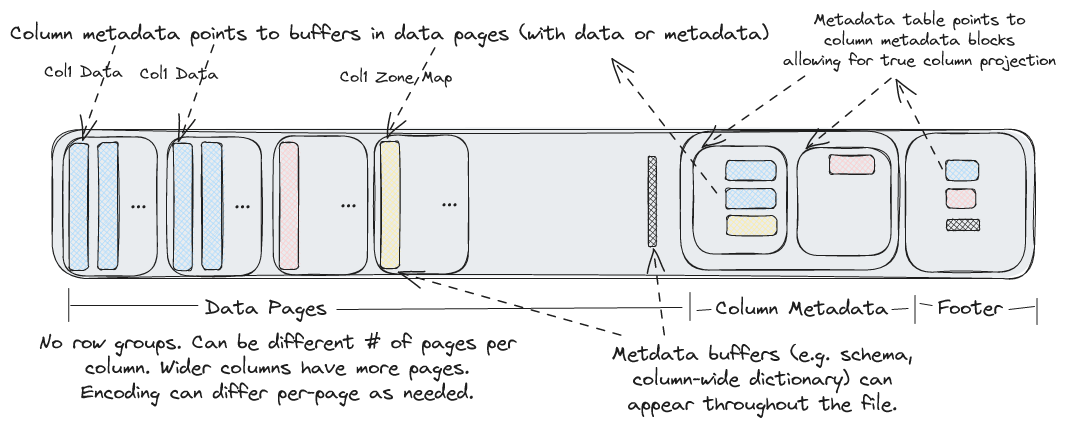

### Imports

In [ ]:
import os
import pandas as pd
import pyarrow as pa
import lance
import time
from tqdm import tqdm

import warnings

warnings.simplefilter("ignore")

### Set the variable according to your Image dataset

Assign the path to your image dataset to the variable `image_dataset`. This dataset should contain your images organized into training, testing, and validation folders. These images will be used to convert them into Lance format.


In [ ]:
image_dataset = "image_dataset"

### Processing the Images

The `process_images` function is the central component of this notebook, responsible for transforming images from the training, testing, and validation folders into Lance format. This format typically includes essential attributes such as `image`, `filename`, `category`, and `data_type`.

Specifically, `image` represents the actual image data, `filename` denotes the name of the file, `category` indicates the category to which the image belongs, and `data_type` specifies whether the image is from the training, testing, or validation set.

In [ ]:
def process_images():
    # Get the current directory path
    current_dir = os.getcwd()
    images_folder = os.path.join(current_dir, image_dataset)
    print(images_folder)

    # Define schema for RecordBatch
    schema = pa.schema(
        [
            ("image", pa.binary()),
            ("filename", pa.string()),
            ("category", pa.string()),
            ("data_type", pa.string()),
        ]
    )

    # Iterate over the data types (train, test, valid)
    for data_type in ["train", "test", "val"]:
        data_type_folder = os.path.join(images_folder, data_type)

        # Iterate over the categories within each data type
        for category in os.listdir(data_type_folder):
            category_folder = os.path.join(data_type_folder, category)

            # Iterate over the images within each category
            for filename in tqdm(
                os.listdir(category_folder), desc=f"Processing {data_type} - {category}"
            ):
                # Construct the full path to the image
                image_path = os.path.join(category_folder, filename)

                # Read and convert the image to a binary format
                with open(image_path, "rb") as f:
                    binary_data = f.read()

                image_array = pa.array([binary_data], type=pa.binary())
                filename_array = pa.array([filename], type=pa.string())
                category_array = pa.array([category], type=pa.string())
                data_type_array = pa.array([data_type], type=pa.string())

                # Yield RecordBatch for each image
                yield pa.RecordBatch.from_arrays(
                    [image_array, filename_array, category_array, data_type_array],
                    schema=schema,
                )

### Creating a Lance Dataset

This function, `write_to_lance`, is designed to convert a PyArrow Table into a Lance dataset. It begins by defining the schema for the Lance dataset, specifying fields such as `image`, `filename`, `category`, and `data_type` , make sure the schema is the same as the one defined in the `process_images` function.

Once the schema is established, the function determines the path for saving the Lance file, leveraging the current working directory and the provided `image_dataset` variable. It then initializes a RecordBatchReader using the defined schema and the data obtained from the `process_images` function.

In [ ]:
# Function to write PyArrow Table to Lance dataset
def write_to_lance():
    # Create an empty RecordBatchIterator
    schema = pa.schema(
        [
            pa.field("image", pa.binary()),
            pa.field("filename", pa.string()),
            pa.field("category", pa.string()),
            pa.field("data_type", pa.string()),
        ]
    )

    # Specify the path where you want to save the Lance file
    current_dir = os.getcwd()
    images_folder = os.path.join(current_dir, image_dataset)
    lance_file_path = os.path.join(images_folder, f"{image_dataset}.lance")

    reader = pa.RecordBatchReader.from_batches(schema, process_images())
    lance.write_dataset(
        reader,
        lance_file_path,
        schema,
    )

### Load a Lance Dataset and Visualize it in Pandas Dataframe

`loading_into_pandas` function is designed to load a Lance dataset into a Pandas dataframe. It let's you see your Lance dataset in a pandas dataframe.

The function takes the path to the Lance file as an argument and returns a pandas dataframe. Make sure the schema is the same as the one defined during the Lance dataset generation, refer to `process_images` function and also make sure the path to the Lance file is correct.

In [ ]:
def loading_into_pandas():
    # Load Lance file from the same folder
    current_dir = os.getcwd()
    images_folder = os.path.join(current_dir, image_dataset)
    uri = os.path.join(images_folder, "image_dataset.lance")

    ds = lance.dataset(uri)

    # Accumulate data from batches into a list
    data = []
    for batch in tqdm(
        ds.to_batches(
            columns=["image", "filename", "category", "data_type"], batch_size=10
        ),
        desc="Loading batches",
    ):
        tbl = batch.to_pandas()
        data.append(tbl)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(data, ignore_index=True)
    print("Pandas DataFrame is ready")
    print("Total Rows: ", df.shape[0])